# Fine-tuning a masked language model (TensorFlow)

Install the Transformers and Datasets libraries to run this notebook.

In [ ]:
!pip install datasets transformers[sentencepiece]
!apt install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 7.3 MB/s 
     |████████████████████████████████| 4.4 MB 69.0 MB/s 
     |████████████████████████████████| 212 kB 71.2 MB/s 
     |████████████████████████████████| 1.1 MB 58.6 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
     |████████████████████████████████| 140 kB 74.8 MB/s 
     |████████████████████████████████| 596 kB 64.2 MB/s 
     |████████████████████████████████| 127 kB 73.6 MB/s 
     |████████████████████████████████| 144 kB 73.2 MB/s 
     |████████████████████████████████| 271 kB 74.5 MB/s 
     |████████████████████████████████| 94 kB 733 kB/s 
     |████████████████████████████████| 6.6 MB 48.7 MB/s 
     |████████████████████████████████| 1.2 MB 44.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib

In [ ]:
import numpy as np
import tensorflow as tf

inputs = tokenizer(text, return_tensors="np")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[0, 1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
# We negate the array before argsort to get the largest, not the smallest, logits
top_5_tokens = np.argsort(-mask_token_logits)[:5].tolist()

for token in top_5_tokens:
    print(f">>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

def tokenize_function(examples):
  result = tokenizer(examples["text"])
  if tokenizer.is_fast:
      result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
  return result

def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

import collections
import numpy as np

# from transformers.data import tf_default_data_collator
from transformers.data.data_collator import tf_default_data_collator
wwm_probability = 0.2


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id

    return tf_default_data_collator(features)

>>> جدیدترین خبرهای «حضور بانوان در ورزشگاه ها»
>>> جدیدترین خبرهای «حضور زنان در ورزشگاه ها»
>>> جدیدترین خبرهای «حضور ورزشکاران در ورزشگاه ها»
>>> جدیدترین خبرهای «حضور من در ورزشگاه ها»
>>> جدیدترین خبرهای «حضور تماشاگران در ورزشگاه ها»


You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "sajjad_ramezani@ind.iust.ac.ir"
!git config --global user.name "Sajjad"

In [ ]:
import pandas as pd
df = pd.read_csv('khabar.csv')
df = df[df['text'].apply(lambda x : len(x.split())>3)]
df.head()

,text,label
0,ارسال به دیگران پرینت ۱۴۰۰/۰۳/۲۴ ۲۳:۰۵:۱۹ فرآی...,1
1,انصراف زاکانی به سود رئیسی صحت دارد؟ - خبرآنلاین,13
2,جوان ترین ثروتمندان جهان را بشناسید | پایگاه...,2
3,خبرگزاری آریا - طرح ملاقات تصويري زندانيان با ...,1
4,جدیدترین خبرهای «حضور تماشاگران در ورزشگاه ها»...,13


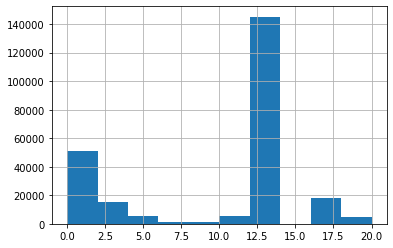

In [ ]:
df['label'].hist()

In [ ]:
labels = list(df['label'].value_counts()[:10].index)

In [ ]:
len_data = df['label'].value_counts()[:10].to_list()

In [2]:
labels = [0,1,10,12,13,16,19,2,3,5]

In [4]:
import pandas as pd

In [8]:
base_path = '/content/drive/MyDrive/NLP/'
l=[]
for la in labels:
    l.append(pd.read_csv(base_path+f'khabar_{la}.csv'))
#   df[df['label']==la].to_csv(base_path+f'khabar_{la}.csv',index=None)

In [9]:
df = pd.concat(l, axis=0, ignore_index=True)
df.head()

,text,label
0,اولین تصویر از لندرور هیدروژنی +عکس - خبر ثریا,0.0
1,ستاره‌ای که از سفر مرگ پیاده شد پیتزا سفارش دا...,0.0
2,انتقادات تند دبیر کمیته صنعت ستاد حجت الاسلام ...,0.0
3,توقیف پراید با ۱۸۹ کیلو تریاک | خبر روز,0.0
4,پليس راه استان البرز | سایت خبری کرج رسا,0.0


In [10]:
df = df[~df['label'].isnull().values]

In [11]:
df['label'] = df['label'].apply(lambda x: int(x))

In [12]:
df = df[~df['text'].isnull().values]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,3),min_df=100)
X_train_counts = count_vect.fit_transform(df.text)
X_train_counts.shape
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tf, df['label'],
                                                    stratify=df['label'], 
                                                    test_size=0.2)

(237350, 4977)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['doc_embed'], df['label'],
                                                    stratify=df['label'], 
                                                    test_size=0.2)
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(class_weight='balanced').fit(np.stack(X_train, axis=0), y_train)
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier().fit(X_train, y_train)

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , plot_confusion_matrix
cm = confusion_matrix(y_test,clf.predict(X_test))
# plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, X_test, y_test,ax=ax)
plt.show() 

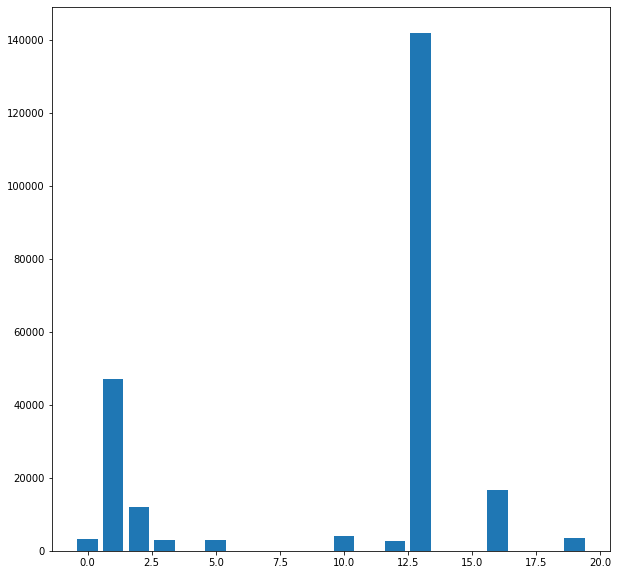

In [ ]:
plt.figure(figsize=(10,10))
plt.bar(df['label'].value_counts().index,df['label'].value_counts().values)
plt.show()

In [14]:
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 31.1 MB/s 
     |████████████████████████████████| 1.4 MB 60.2 MB/s 
     |████████████████████████████████| 233 kB 69.9 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394486 sha256=867135b9c5695c85eb1fdce635781565683298b4c8b7e2a8c3a6c82c0273f974
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154943 sha256=a1af0e509b70345e876aa6022dff6e1d3ebd889e5b8d6c31d29eedde4ddbb98a
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [15]:
from hazm import word_tokenize

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [17]:
from keras.utils.np_utils import to_categorical
categorical_labels = to_categorical(df['label'])


In [18]:
import numpy as np

In [ ]:

# X_train, X_test, y_train, y_test = train_test_split(df['doc_embed'], categorical_labels,
#                                                     stratify=df['label'], 
#                                                     test_size=0.2)

In [ ]:
model_clf = keras.Sequential(
    [
        layers.Dense(128, activation="relu", name="layer1"),
        layers.Dense(64, activation="relu", name="layer2"),
        layers.Dropout(0.2),
        layers.Dense(20,activation='softmax', name="layer3"),
    ]
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tf, categorical_labels,
                                                    stratify=df['label'], 
                                                    test_size=0.2)
X_train.shape

# model_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model_clf.fit(X_train, y_train,
                    epochs=5,
                    batch_size=128)

In [ ]:
y_pred = np.argmax(model_clf.predict(X_test),axis=1)
y_pred.shape
df['label'].shape
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test,axis=1), y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.show()


(47470,)

## RNN

In [ ]:
max_features = 4978  # number of words to consider as features
maxlen = 30  # cut texts after this number of words (among top max_features most common words)

df['seq'] = df['text'].apply(lambda x : list(map(lambda y:count_vect.vocabulary_.get(y,4978),tf.keras.preprocessing.text.text_to_word_sequence(x))))
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(64, return_sequences=True))
model.summary()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['seq'], categorical_labels,
                                                    stratify=df['label'], 
                                                    test_size=0.2)
(input_train, y_train), (input_test, y_test) = (X_train, y_train) ,(X_test, y_test)
from keras.datasets import imdb
from keras.preprocessing import sequence


# print('Loading data...')
# (input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
# print(len(input_train), 'train sequences')
# print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

In [ ]:
# model = Sequential()
# model.add(Embedding(max_features, 32))
# model.add(layers.LSTM(32,dropout=0.2,return_sequences=True))
# model.add(layers.LSTM(32,dropout=0.2,return_sequences=False))
# model.add(layers.Dense(20, activation='softmax'))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.05)

Epoch 1/20
1410/1410 [==============================] - 15s 11ms/step - loss: 0.2815 - acc: 0.9096 - val_loss: 0.3695 - val_acc: 0.8854
Epoch 2/20
1410/1410 [==============================] - 11s 8ms/step - loss: 0.2776 - acc: 0.9116 - val_loss: 0.3683 - val_acc: 0.8843
Epoch 3/20
1410/1410 [==============================] - 10s 7ms/step - loss: 0.2752 - acc: 0.9118 - val_loss: 0.3709 - val_acc: 0.8868
Epoch 4/20
1410/1410 [==============================] - 10s 7ms/step - loss: 0.2725 - acc: 0.9126 - val_loss: 0.3745 - val_acc: 0.8843
Epoch 5/20
1410/1410 [==============================] - 10s 7ms/step - loss: 0.2700 - acc: 0.9137 - val_loss: 0.3754 - val_acc: 0.8852
Epoch 6/20
1410/1410 [==============================] - 10s 7ms/step - loss: 0.2681 - acc: 0.9138 - val_loss: 0.3735 - val_acc: 0.8855
Epoch 7/20
1410/1410 [==============================] - 10s 7ms/step - loss: 0.2663 - acc: 0.9147 - val_loss: 0.3733 - val_acc: 0.8860
Epoch 8/20
1410/1410 [==============================] 

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          159264    
                                                                 
 lstm_2 (LSTM)               (None, None, 32)          8320      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 20)                660       
                                                                 
Total params: 176,564
Trainable params: 176,564
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.save(base_path+'calssification/LSTM')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/calssification/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/calssification/LSTM/assets


In [ ]:
model_clf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 128)               637184    
                                                                 
 layer2 (Dense)              (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 layer3 (Dense)              (None, 20)                1300      
                                                                 
Total params: 646,740
Trainable params: 646,740
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_clf.save(base_path+'calssification/dense')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/calssification/dense/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/calssification/dense/assets


## Transformers

In [19]:
# Install required packages

!pip install -q transformers
!pip install -q hazm
!pip install -q clean-text[gpl]

     |████████████████████████████████| 4.4 MB 35.8 MB/s 
     |████████████████████████████████| 6.6 MB 45.6 MB/s 
     |████████████████████████████████| 596 kB 71.1 MB/s 
     |████████████████████████████████| 101 kB 13.6 MB/s 
     |████████████████████████████████| 175 kB 33.7 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 235 kB 70.3 MB/s 


In [21]:
# Import required packages

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

# import plotly.express as px
# import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import json
import copy
import collections

In [22]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [23]:
data = df.copy()

In [24]:
import re
minlim, maxlim = 3, 256

In [25]:
# cleaning comments
data['cleaned_comment'] = data['text'].apply(cleaning)


# calculate the length of comments based on their words
data['cleaned_comment_len_by_words'] = data['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

# remove comments with the length of fewer than three words
data['cleaned_comment_len_by_words'] = data['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
data = data.dropna(subset=['cleaned_comment_len_by_words'])
data = data.reset_index(drop=True)

data.head()

,text,label,cleaned_comment,cleaned_comment_len_by_words
0,اولین تصویر از لندرور هیدروژنی +عکس - خبر ثریا,0,اولین تصویر از لندرور هیدروژنی +عکس - خبر ثریا,9
1,ستاره‌ای که از سفر مرگ پیاده شد پیتزا سفارش دا...,0,ستاره‌ای که از سفر مرگ پیاده شد پیتزا سفارش دا...,13
2,انتقادات تند دبیر کمیته صنعت ستاد حجت الاسلام ...,0,انتقادات تند دبیر کمیته صنعت ستاد حجت الاسلام ...,55
3,توقیف پراید با ۱۸۹ کیلو تریاک | خبر روز,0,توقیف پراید با ۱۸۹ کیلو تریاک | خبر روز,9
4,پليس راه استان البرز | سایت خبری کرج رسا,0,پلیس راه استان البرز | سایت خبری کرج رسا,9


In [26]:
data[['text','cleaned_comment']].to_csv(base_path+'khabar_cleaned.csv')

In [27]:
data = data[['cleaned_comment', 'label']]
data.columns = ['comment', 'label']
data.head()

,comment,label
0,اولین تصویر از لندرور هیدروژنی +عکس - خبر ثریا,0
1,ستاره‌ای که از سفر مرگ پیاده شد پیتزا سفارش دا...,0
2,انتقادات تند دبیر کمیته صنعت ستاد حجت الاسلام ...,0
3,توقیف پراید با ۱۸۹ کیلو تریاک | خبر روز,0
4,پلیس راه استان البرز | سایت خبری کرج رسا,0


In [28]:
labels

[0, 1, 10, 12, 13, 16, 19, 2, 3, 5]

In [29]:
data['label_id'] = data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(data, test_size=0.2, random_state=1, stratify=data['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(170892, 3)
(18988, 3)
(47470, 3)


In [30]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [32]:
# general config
MAX_LEN = 30
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [35]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

# setup the tokenizer and configuration

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

idx = np.random.randint(0, len(train))
sample_comment = train.iloc[idx]['comment']
sample_label = train.iloc[idx]['label']

print(f'Sample: \n{sample_comment}\n{sample_label}')

tokens = tokenizer.tokenize(sample_comment)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Comment: {sample_comment}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')


encoding = tokenizer.encode_plus(
    sample_comment,
    max_length=32,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

label2id: {0: 0, 1: 1, 10: 2, 12: 3, 13: 4, 16: 5, 19: 6, 2: 7, 3: 8, 5: 9}
id2label: {0: 0, 1: 1, 2: 10, 3: 12, 4: 13, 5: 16, 6: 19, 7: 2, 8: 3, 9: 5}


Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440 [00:00<?, ?B/s]

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": 0,
    "1": 1,
    "2": 10,
    "3": 12,
    "4": 13,
    "5": 16,
    "6": 19,
    "7": 2,
    "8": 3,
    "9": 5
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "0": 0,
    "1": 1,
    "2": 7,
    "3": 8,
    "5": 9,
    "10": 2,
    "12": 3,
    "13": 4,
    "16": 5,
    "19": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}

Sample: 
ماجرای قتل خانوادگی از زبان قاتل که اجساد را در کومله دفن کرد! | پایگاه اطلاع رسانی لنگرخبر – لنگرود
19
  Comment: ماجرای قتل خانوادگی از 

In [33]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [40]:
train

,comment,label,label_id
0,کنایه و تحقیر آمریکا با انتشار عکسی از سوی طال...,1,1
1,بهبودی ترافیک بهرود - خبرگزاری آریا,13,4
2,جدیدترین خبرهای «سرآسیاب بهمئی» - خبربان,13,4
3,پرویز پرستویی: سلام‌‌مان بوی نیاز ندهد | پایگا...,13,4
4,واکنش وزیر بهداشت دولت اول روحانی به خبر نامزد...,1,1
...,...,...,...
170887,آخرین اخبار «شورای هماهنگی بانک‌ها» - ۶ - خبربان,13,4
170888,خبر بد برای بارسلونا در آستانه بازی با چلسی,16,5
170889,تکذیب دوباره خبر پرس‌تی‌وی از قول «منابع آگاه»...,1,1
170890,تبریک تولد ۳۳ سالگی اشکان دژاگه توسط باشگاه ول...,13,4


In [41]:
label_list = list(map(str,labels))
train_data_loader = create_data_loader(train['comment'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['comment'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['comment'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [42]:
sample_data = next(iter(train_data_loader))

print(sample_data.keys())

print(sample_data['comment'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'].shape)
print(sample_data['targets'][0])

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
['کنایه و تحقیر آمریکا با انتشار عکسی از سوی طالبان | خبرگزاری شیعیان افغانستان | afghanistan - shia news agency', 'بهبودی ترافیک بهرود - خبرگزاری آریا', 'جدیدترین خبرهای «سرآسیاب بهمئی» - خبربان', 'پرویز پرستویی: سلام\u200c\u200cمان بوی نیاز ندهد | پایگاه خبری تحلیلی سینما سینما', 'واکنش وزیر بهداشت دولت اول روحانی به خبر نامزدی\u200cاش در انتخابات ۱۴۰۰', 'آخرین اخبار «شورای حل اختلاف استان البرز» - خبربان', 'اقدام عجیب فیفا در حمایت از عربستان و امارات/ «رنکینگ» خلق\u200cالساعه - خبرگزاری مهر', 'جدیدترین خبرهای «بیمه تکمیلی» - خبربان', 'آخرین اخبار «شهید رجبعلی» - خبربان', 'سقوط هواپیمای آموزشی در اراضی کشاورزی چادگان | پایگاه خبری صد آنلاین', 'طلای سفید افغانستان به بهایی ناچیز+تصاویر | خبرگزاری شیعیان افغانستان | afghanistan - shia news agency', 'بمب خبری در استقلال', 'فیلم: داعش، بینی یکی از باشندگان حلب را برید! | خبرگزاری شیعیان افغانستان | afghanistan - shia news agency', 'جدیدترین خبرهای «شهرضا»

In [58]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids,return_dict=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

0.1

In [59]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [51]:
sample_data_targets

tensor([1, 4, 4, 4, 1, 4, 1, 4, 4, 1, 7, 5, 1, 4, 0, 5], device='cuda:0')

In [60]:
# sample data output

sample_data_comment = sample_data['comment']
sample_data_input_ids = sample_data['input_ids']
sample_data_attention_mask = sample_data['attention_mask']
sample_data_token_type_ids = sample_data['token_type_ids']
sample_data_targets = sample_data['targets']

# available for using in GPU
sample_data_input_ids = sample_data_input_ids.to(device)
sample_data_attention_mask = sample_data_attention_mask.to(device)
sample_data_token_type_ids = sample_data_token_type_ids.to(device)
sample_data_targets = sample_data_targets.to(device)


# outputs = F.softmax(
#     pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids), 
#     dim=1)

outputs = pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids)
_, preds = torch.max(outputs, dim=1)

print(outputs[:5, :])
print(preds[:5])

tensor([[-0.0111,  0.1683, -0.5240,  0.3495,  0.1619,  0.3600,  0.2627, -0.0499,
         -0.1045,  0.1815],
        [ 0.2851,  0.2877,  0.0617,  0.3692,  0.1630,  0.1835,  0.0514,  0.2485,
         -0.0362, -0.2664],
        [ 0.1015,  0.5399, -0.1828, -0.1477,  0.1923,  0.3696,  0.0644, -0.1012,
         -0.1360, -0.4897],
        [ 0.2373,  0.1092, -0.2534,  0.2745, -0.2251,  0.3248,  0.1624,  0.0945,
         -0.0232, -0.3536],
        [-0.0332,  0.2743, -0.2014,  0.0563,  0.2383,  0.2400,  0.2591, -0.2021,
          0.2143, -0.1670]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([5, 3, 1, 5, 1], device='cuda:0')


In [61]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/10681 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/1187 [00:00<?, ?it/s]

Epoch: 1/3...Step: 1000...Train Loss: 0.496246...Train Acc: 0.847...Valid Loss: 0.383944...Valid Acc: 0.879...
Validation loss decreased (inf --> 0.383944).  Saving model ...


Evaluation... :   0%|          | 0/1187 [00:00<?, ?it/s]

Epoch: 1/3...Step: 2000...Train Loss: 0.428954...Train Acc: 0.868...Valid Loss: 0.356319...Valid Acc: 0.889...
Validation loss decreased (0.383944 --> 0.356319).  Saving model ...


Evaluation... :   0%|          | 0/1187 [00:00<?, ?it/s]

Epoch: 1/3...Step: 3000...Train Loss: 0.397785...Train Acc: 0.878...Valid Loss: 0.326891...Valid Acc: 0.897...
Validation loss decreased (0.356319 --> 0.326891).  Saving model ...


Evaluation... :   0%|          | 0/1187 [00:00<?, ?it/s]

Epoch: 1/3...Step: 4000...Train Loss: 0.381424...Train Acc: 0.882...Valid Loss: 0.313310...Valid Acc: 0.902...
Validation loss decreased (0.326891 --> 0.313310).  Saving model ...


Evaluation... :   0%|          | 0/1187 [00:00<?, ?it/s]

Epoch: 1/3...Step: 5000...Train Loss: 0.371057...Train Acc: 0.885...Valid Loss: 0.310325...Valid Acc: 0.904...
Validation loss decreased (0.313310 --> 0.310325).  Saving model ...


In [ ]:
for ra,la in enumerate(labels[6:]):
  try:
    from transformers import TFAutoModelForMaskedLM

    model_checkpoint = "HooshvareLab/bert-fa-base-uncased"
    model = TFAutoModelForMaskedLM.from_pretrained(model_checkpoint)
    model(model.dummy_inputs)  # Build the model
    # model.summary()
    from transformers import AutoTokenizer

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    from datasets import load_dataset

    imdb_dataset = load_dataset('csv',column_names=['text', 'label'],data_files ={'train': base_path+f"khabar_{la}.csv",'test':'/content/sample_khabar.csv'})
    # imdb_dataset = load_dataset('imdb')

    # Use batched=True to activate fast multithreading!
    tokenized_datasets = imdb_dataset.map(
        tokenize_function, batched=True, remove_columns=["text", "label"]
    )
    chunk_size = 128


    lm_datasets = tokenized_datasets.map(group_texts, batched=True)

    from transformers import DataCollatorForLanguageModeling

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

    train_size = 0.99
    test_size = 0.01

    downsampled_dataset = lm_datasets["train"].train_test_split(
        train_size=train_size, test_size=test_size, seed=42
    )
    tf_train_dataset = downsampled_dataset["train"].to_tf_dataset(
        columns=["input_ids", "attention_mask", "labels"],
        collate_fn=data_collator,
        shuffle=True,
        batch_size=32,
    )

    tf_eval_dataset = downsampled_dataset["test"].to_tf_dataset(
        columns=["input_ids", "attention_mask", "labels"],
        collate_fn=data_collator,
        shuffle=False,
        batch_size=32,
    )

    from transformers import create_optimizer
    from transformers.keras_callbacks import PushToHubCallback
    import tensorflow as tf

    num_train_steps = len(tf_train_dataset)
    optimizer, schedule = create_optimizer(
        init_lr=2e-5,
        num_warmup_steps=1_000,
        num_train_steps=num_train_steps,
        weight_decay_rate=0.01,
    )
    model.compile(optimizer=optimizer)

    # Train in mixed-precision float16
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

    # callback = PushToHubCallback(
    #     output_dir=f"{model_name}-finetuned-imdb", tokenizer=tokenizer
    # )

    import math

    eval_loss = model.evaluate(tf_eval_dataset)
    print(f"Perplexity: {math.exp(eval_loss):.2f}")

    model.fit(tf_train_dataset, validation_data=tf_eval_dataset,epochs=5)

    eval_loss = model.evaluate(tf_eval_dataset)
    print(f"Perplexity: {math.exp(eval_loss):.2f}")

    ts = ['فرآیند کاهش آمارهای کرونا در تهران [MASK] است',
          'انصراف [MASK] به سود رئیسی صحت دارد',
          'جدیدترین خبرهای «حضور [MASK] در ورزشگاه ها»',
          'دوست جون ها شماها چه جوری خبر [MASK] به شوهرتون دادید',
          'کدام ستاره ها بالاترین [MASK] را دارند']
    for text in ts:
      inputs = tokenizer(text, return_tensors="np")
      token_logits = model(**inputs).logits
      # Find the location of [MASK] and extract its logits
      mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[0, 1]
      mask_token_logits = token_logits[0, mask_token_index, :]
      # Pick the [MASK] candidates with the highest logits
      # We negate the array before argsort to get the largest, not the smallest, logits
      top_5_tokens = np.argsort(-mask_token_logits)[:5].tolist()
      print(text)
      for token in top_5_tokens:
          print(f">>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

    model.save(base_path+f'models/model_khabar_online_{la}.md')
  except:
    continue


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-9a82678b150e3416/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


1/1 [==============================] - 3s 3s/step - loss: 3.2422
Perplexity: 25.59
Epoch 1/5
14/14 [==============================] - 29s 463ms/step - loss: 3.9167 - val_loss: 3.6582
Epoch 2/5
14/14 [==============================] - 7s 464ms/step - loss: 3.8053 - val_loss: 3.7305
Epoch 3/5
14/14 [==============================] - 7s 466ms/step - loss: 3.6882 - val_loss: 4.5664
Epoch 4/5
14/14 [==============================] - 7s 468ms/step - loss: 3.5887 - val_loss: 2.9980
Epoch 5/5
1/1 [==============================] - 0s 77ms/step - loss: 3.1367
Perplexity: 23.03
فرآیند کاهش آمارهای کرونا در تهران [MASK] است
>>> فرآیند کاهش آمارهای کرونا در تهران زمانبر است
>>> فرآیند کاهش آمارهای کرونا در تهران تدریجی است
>>> فرآیند کاهش آمارهای کرونا در تهران چگونه است
>>> فرآیند کاهش آمارهای کرونا در تهران ضروری است
>>> فرآیند کاهش آمارهای کرونا در تهران متفاوت است
انصراف [MASK] به سود رئیسی صحت دارد
>>> انصراف قالیباف به سود رئیسی صحت دارد
>>> انصراف بقایی به سود رئیسی صحت دارد
>>> انصراف میرس

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_0.md/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_0.md/assets
All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c8426901c5362101/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


1/1 [==============================] - 3s 3s/step - loss: 4.7617
Perplexity: 116.95
Epoch 1/5
14/14 [==============================] - 29s 462ms/step - loss: 4.5252 - val_loss: 4.2656
Epoch 2/5
14/14 [==============================] - 7s 464ms/step - loss: 4.5552 - val_loss: 5.0312
Epoch 3/5
14/14 [==============================] - 7s 464ms/step - loss: 4.4215 - val_loss: 4.1211
Epoch 4/5
14/14 [==============================] - 7s 468ms/step - loss: 4.3186 - val_loss: 4.7852
Epoch 5/5
1/1 [==============================] - 0s 76ms/step - loss: 2.7285
Perplexity: 15.31
فرآیند کاهش آمارهای کرونا در تهران [MASK] است
>>> فرآیند کاهش آمارهای کرونا در تهران زمانبر است
>>> فرآیند کاهش آمارهای کرونا در تهران تدریجی است
>>> فرآیند کاهش آمارهای کرونا در تهران چگونه است
>>> فرآیند کاهش آمارهای کرونا در تهران ضروری است
>>> فرآیند کاهش آمارهای کرونا در تهران متفاوت است
انصراف [MASK] به سود رئیسی صحت دارد
>>> انصراف قالیباف به سود رئیسی صحت دارد
>>> انصراف بقایی به سود رئیسی صحت دارد
>>> انصراف میر

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_5.md/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_5.md/assets
All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-74115c81f367c69c/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


1/1 [==============================] - 6s 6s/step - loss: 2.7852
Perplexity: 16.20
Epoch 1/5
26/26 [==============================] - 34s 484ms/step - loss: 2.8008 - val_loss: 2.2285
Epoch 2/5
26/26 [==============================] - 13s 485ms/step - loss: 2.8211 - val_loss: 2.5078
Epoch 3/5
26/26 [==============================] - 13s 491ms/step - loss: 2.7614 - val_loss: 1.8115
Epoch 4/5
26/26 [==============================] - 13s 493ms/step - loss: 2.6237 - val_loss: 2.2871
Epoch 5/5
1/1 [==============================] - 0s 93ms/step - loss: 2.0625
Perplexity: 7.87
فرآیند کاهش آمارهای کرونا در تهران [MASK] است
>>> فرآیند کاهش آمارهای کرونا در تهران چگونه است
>>> فرآیند کاهش آمارهای کرونا در تهران زمانبر است
>>> فرآیند کاهش آمارهای کرونا در تهران تدریجی است
>>> فرآیند کاهش آمارهای کرونا در تهران ضروری است
>>> فرآیند کاهش آمارهای کرونا در تهران چقدر است
انصراف [MASK] به سود رئیسی صحت دارد
>>> انصراف قالیباف به سود رئیسی صحت دارد
>>> انصراف میرسلیم به سود رئیسی صحت دارد
>>> انصراف بق

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_3.md/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_3.md/assets
All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-40c26a43d079d10d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


1/1 [==============================] - 3s 3s/step - loss: 4.6133
Perplexity: 100.81
Epoch 1/5
11/11 [==============================] - 25s 491ms/step - loss: 5.4664 - val_loss: 5.0000
Epoch 2/5
11/11 [==============================] - 6s 499ms/step - loss: 5.4059 - val_loss: 4.2031
Epoch 3/5
11/11 [==============================] - 5s 489ms/step - loss: 5.3682 - val_loss: 5.9766
Epoch 4/5
11/11 [==============================] - 5s 495ms/step - loss: 5.2538 - val_loss: 5.4180
Epoch 5/5
1/1 [==============================] - 0s 72ms/step - loss: 5.8672
Perplexity: 353.25
فرآیند کاهش آمارهای کرونا در تهران [MASK] است
>>> فرآیند کاهش آمارهای کرونا در تهران زمانبر است
>>> فرآیند کاهش آمارهای کرونا در تهران تدریجی است
>>> فرآیند کاهش آمارهای کرونا در تهران چگونه است
>>> فرآیند کاهش آمارهای کرونا در تهران ضروری است
>>> فرآیند کاهش آمارهای کرونا در تهران متفاوت است
انصراف [MASK] به سود رئیسی صحت دارد
>>> انصراف قالیباف به سود رئیسی صحت دارد
>>> انصراف بقایی به سود رئیسی صحت دارد
>>> انصراف می

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_12.md/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_12.md/assets


In [ ]:
141931 /128

1108.8359375

In [ ]:
imdb_dataset.data['train'][0]

[
  [
    "text",
    "انصراف زاکانی به سود رئیسی صحت دارد؟ - خبرآنلاین",
    "جدیدترین خبرهای «حضور تماشاگران در ورزشگاه ها»  - خبربان",
    "جدیدترین خبرهای «منطقه مشیریه»  - خبربان",
    "آخرین اخبار «نفر تایید شدند»  - ۶ - خبربان",
    "کدام ستاره ها بالاترین آی کیو را دارند؟ | خبرگزاری شیعیان افغانستان | Afghanistan - Shia News Agency",
    "جدیدترین خبرهای «نتایج آزمون استخدام»  - خبربان",
    "جدیدترین خبرهای «بيمه قالي بافي»  - خبربان",
    "خبرگزاری آریا - موفقيت «نام من فرانچسکو توتي است» در جشنواره روتردام",
    "آموزش سرمایه گذاری در مسکن و طلا توسط مستر تریدر - خبرگزاری برنا",
    ...
    "جدیدترین خبرهای «قیمت خودرو شاهین سایپا»  - خبربان",
    "مهاجرت و پناهندگی؛ قصه متفاوت توکیو 2020 - خبرآنلاین",
    "جدیدترین خبرهای «بازی های دوستانه ملی»  - خبربان",
    "جدیدترین خبرهای «نتیجه بازی سپاهان پرسپولیس»  - خبربان",
    "آخرین اخبار «سرپرست جدید آموزش و پرورش»  - خبربان",
    "جدیدترین خبرهای «صندلی ایستاده»  - خبربان",
    "جدیدترین خبرهای «فرمانداری ری»  - خبربان",
    "

In [ ]:
model_name='ss'

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


1/1 [==============================] - 8s 8s/step - loss: 3.4144
Perplexity: 30.40


Epoch 1/5
313/313 [==============================] - 451s 1s/step - loss: 2.2263 - val_loss: 2.1412
Epoch 2/5
313/313 [==============================] - 455s 1s/step - loss: 2.2296 - val_loss: 2.0752
Epoch 3/5
313/313 [==============================] - 455s 1s/step - loss: 2.2173 - val_loss: 2.2105
Epoch 4/5
313/313 [==============================] - 455s 1s/step - loss: 2.2064 - val_loss: 2.1000
Epoch 5/5
313/313 [==============================] - 456s 1s/step - loss: 2.2127 - val_loss: 2.1414


4/4 [==============================] - 2s 340ms/step - loss: 2.1787
Perplexity: 8.83


In [ ]:
from transformers import pipeline

mask_filler = pipeline(
    "fill-mask", model="huggingface-course/distilbert-base-uncased-finetuned-imdb"
)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
preds = mask_filler(text)

for pred in preds:
    print(f">>> {pred['sequence']}")

>>> بابا ابي.
>>> بابا ابه.
>>> بابا ابد.
>>> بابا ابا.
>>> بابا ابو.


In [ ]:
model.save("model_khabar_online.md")

INFO:tensorflow:Assets written to: model_khabar_online.md/assets


INFO:tensorflow:Assets written to: model_khabar_online.md/assets


In [ ]:
text = "بابا اب  [MASK]."

In [ ]:
import pandas as pd
df = pd.read_csv('/content/sample_khabar.csv')

In [ ]:
 for r in df['text'].iloc[:10]:
   print(r)

ارسال به دیگران پرینت ۱۴۰۰/۰۳/۲۴ ۲۳:۰۵:۱۹ فرآیند کاهش آمارهای کرونا در تهران کند است تهران- فرمانده ستاد مقابله با کرونا در تهران از کاهش ۱۷.۵ درصدی جانباختگان بر اثر کرونا در پایتخت خبر داد و گفت: فرآیند کاهش آمارهای کرونا در تهران کند است.
انصراف زاکانی به سود رئیسی صحت دارد؟ - خبرآنلاین
  جوان ترین ثروتمندان جهان را بشناسید | پایگاه خبری تحلیلی عصر گیلان
خبرگزاری آریا - طرح ملاقات تصويري زندانيان با خانواده‌‎هايشان عملياتي شد
جدیدترین خبرهای «حضور تماشاگران در ورزشگاه ها»  - خبربان
دوست جون ها شماها چه جوری خبر بارداریتونو به شوهرتون دادید؟
جدیدترین خبرهای «منطقه مشیریه»  - خبربان
آخرین اخبار «نفر تایید شدند»  - ۶ - خبربان
کدام ستاره ها بالاترین آی کیو را دارند؟ | خبرگزاری شیعیان افغانستان | Afghanistan - Shia News Agency
جدیدترین خبرهای «نتایج آزمون استخدام»  - خبربان


In [ ]:
ts = ['فرآیند کاهش آمارهای کرونا در تهران [MASK] است',
      'انصراف [MASK] به سود رئیسی صحت دارد',
      'جدیدترین خبرهای «حضور [MASK] در ورزشگاه ها»',
      'دوست جون ها شماها چه جوری خبر [MASK] به شوهرتون دادید',
      'کدام ستاره ها بالاترین [MASK] را دارند']
for text in ts:
  inputs = tokenizer(text, return_tensors="np")
  token_logits = model(**inputs).logits
  # Find the location of [MASK] and extract its logits
  mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[0, 1]
  mask_token_logits = token_logits[0, mask_token_index, :]
  # Pick the [MASK] candidates with the highest logits
  # We negate the array before argsort to get the largest, not the smallest, logits
  top_5_tokens = np.argsort(-mask_token_logits)[:5].tolist()
  print(text)
  for token in top_5_tokens:
      print(f">>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

In [ ]:
!zip model.zip -r /content/model_khabar_online.md 

  adding: content/model_khabar_online.md/ (stored 0%)
  adding: content/model_khabar_online.md/variables/ (stored 0%)
  adding: content/model_khabar_online.md/variables/variables.index (deflated 81%)
  adding: content/model_khabar_online.md/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model_khabar_online.md/saved_model.pb (deflated 92%)
  adding: content/model_khabar_online.md/assets/ (stored 0%)
  adding: content/model_khabar_online.md/keras_metadata.pb (deflated 95%)
